In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import blip_analysis as ba
import numpy as np
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from copy import deepcopy
from sklearn.cluster import KMeans
from matplotlib.gridspec import GridSpec
from label_axes import label_axes
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

b


In [2]:
### Load in data
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [3]:
### Calculate the mean of the usrts
unit_usrt_j = np.concatenate((unit_usrt1[good_indexes], unit_usrt2[good_indexes], unit_usrt3[good_indexes]), axis=0)
mean_usrt1 = np.array([[i.mean() for i in j] for j in unit_usrt1[good_indexes]])
mean_usrt2 = np.array([[i.mean() for i in j] for j in unit_usrt2[good_indexes]])
mean_usrt3 = np.array([[i.mean() for i in j] for j in unit_usrt3[good_indexes]])
mean_all_usrt = np.concatenate((mean_usrt1, mean_usrt2, mean_usrt3), axis=0)
norm_mean_all_usrt = (mean_all_usrt - np.min(mean_all_usrt, axis=-1)[:, np.newaxis])/(np.max(mean_all_usrt, axis=-1)[:, np.newaxis] - np.min(mean_all_usrt, axis=-1)[: ,np.newaxis])

In [4]:
### Load in the fit models
diff_models1 = pickle.Unpickler(open('../Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Data/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Data/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Data/230320_conc_models1.pkl', 'rb')).load()
diff_models_j = np.concatenate((diff_models1, diff_models2, diff_models3), axis=0)



In [5]:
### Extract the bins
bins1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1]).mean(axis=1)
bins2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2]).mean(axis=1)
bins3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3]).mean(axis=1)

all_preds = [i.pred_resp for i in diff_models1] + [i.pred_resp for i in diff_models2] + [i.pred_resp for i in diff_models3]
all_trues = [i.true_resp for i in diff_models1] + [i.true_resp for i in diff_models2] + [i.true_resp for i in diff_models3]


In [6]:
### Apply PCA to the bins
pca1 = PCA(n_components=9)
fit_bins1 = pca1.fit_transform(bins1)
fit_1_pc12 = deepcopy(fit_bins1)
fit_1_pc12[:, 2:] = 0
bins_1_pc12 = pca1.inverse_transform(fit_1_pc12)


pca2 = PCA(n_components=9)
fit_bins2 = pca2.fit_transform(bins2)
fit_2_pc12 = fit_bins2.copy()
fit_2_pc12[:, 2:] = 0
bins_2_pc12 = pca2.inverse_transform(fit_2_pc12)

pca3 = PCA(n_components=9)
fit_bins3 = pca3.fit_transform(bins3)
fit_3_pc12 = fit_bins3.copy()
fit_3_pc12[:, 2:] = 0
bins_3_pc12 = pca3.inverse_transform(fit_3_pc12)

pca_all = PCA(n_components=9)
all_bins = np.concatenate([bins1 , bins2 , bins3], axis=0)
fit_bins_all = pca_all.fit_transform(all_bins)
fit_all_pc12 = fit_bins_all.copy()
fit_all_pc12[:, 2:] = 0
bins_all_pc12 = pca_all.inverse_transform(fit_all_pc12)

In [7]:
### Generate the predicted distributions along PC1 and PC2
pc1_exp_decay = np.abs([i - np.median(fit_bins_all[:, 0]) for i in fit_bins_all[:, 0]]).mean()
pc2_exp_decay = np.abs([i - np.median(fit_bins_all[:, 1]) for i in fit_bins_all[:, 1]]).mean()
rand1 = np.random.laplace(0, pc1_exp_decay, 10000)
rand2 = np.random.laplace(0, pc2_exp_decay, 10000)

In [8]:
def plot_response_map(fig, gs, max_counts, titles=False):
    '''Makes the big response map in B needs to be run TWICE to get the correct max_count heatmap scaling'''
    sub_gs = gs.subgridspec(10, 10)
    ax = np.array([[fig.add_subplot(sub_gs[i, j]) for j in range(10)] for i in range(10)])
    pc1_quants = [np.quantile(fit_bins_all[:, 0], i) for i in np.arange(0.00, 1.05, 0.1)]
    pc2_quants = [np.quantile(fit_bins_all[:, 1], i) for i in np.arange(0.00, 1.05, 0.1)]
    pc2_quants = pc2_quants[::-1]
    counts = []
    density = False
    comp = False
    select_cells = range(390)
    for i in range(len(pc1_quants)-1):
        for j in range(len(pc2_quants)-1):
            count = np.where((fit_bins_all[select_cells, 0] < pc1_quants[i+1]) & (fit_bins_all[select_cells, 1] >= pc2_quants[j+1]) 
                            & (fit_bins_all[select_cells, 0] >= pc1_quants[i]) & (fit_bins_all[select_cells, 1] < pc2_quants[j]))[0].shape[0]
            counts_lap = np.where((rand1 < pc1_quants[i+1]) & (rand2 >= pc2_quants[j+1])
                                & (rand1 >= pc1_quants[i]) & (rand2 < pc2_quants[j]))[0].shape[0]
            
            #count = np.where((fit_bins_all[:, 0] < i+0.05) & (fit_bins_all[:, 1] < j+0.05) & (fit_bins_all[:, 0] >= i - 0.05) & (fit_bins_all[:, 1] >= j - 0.05))[0].shape[0]
            #print(count)
            if density:
                count = count/len(select_cells)
                counts_lap = counts_lap/len(rand1)
            if comp:
                count = count - counts_lap
            #print(pca_all.components_[0]*pc1_steps[i]+0.25 + pca_all.components_[1]*pc2_steps[j]-0.25)
            counts.append(count)
            if comp:    
                ax[j, i].set_facecolor(mpl.cm.bwr(count/(2*max_counts) + 0.5))
            else:
                ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
            w = pca_all.components_[0]*((pc1_quants[i]+pc1_quants[i+1])/2) + pca_all.components_[1]*((pc2_quants[j]+pc2_quants[j+1])/2)
            pred_fits = np.exp(diff_models1[0].trial_array @ w)
            ax[j, i].plot(pred_fits,c='k')
            # ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
            ax[j, i].set_yticklabels([])
            if titles:
                ax[j, i].set_title(f'{(pc1_quants[i]+pc1_quants[i+1])/2:.2f} {(pc2_quants[j]+pc2_quants[j+1])/2:.2f}', fontsize=10)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['top'].set_visible(False)
    counts = np.array(counts)
    max_counts = np.max(counts)
    [i.set_xticks(range(32)) for i in ax[-1, :]]
    [i.set_xticklabels(glyphs, rotation=90, fontsize=5) for i in ax[-1, :]]
    return max_counts

def plot_scatter_and_pos(ax):
    '''Plots the coefficients for each cell in PC1 and PC2'''
    odour_grays = ['k', 'gray', 'lightgray']
    markers = ['o', 's', 'd']
    ax.scatter(fit_bins1[:, 0], fit_bins1[:, 1], c=odour_grays[0], marker=markers[0], label='EB')
    ax.scatter(fit_bins2[:, 0], fit_bins2[:, 1], c=odour_grays[1], marker=markers[1], label='IA')
    ax.scatter(fit_bins3[:, 0], fit_bins3[:, 1], c=odour_grays[2], marker=markers[2], label='EA')

    for i in pc1_quants:
        ax.axvline(i, c='k', alpha=0.5)
    for i in pc2_quants:
        ax.axhline(i, c='k', alpha=0.5)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    max_lim = np.max(np.abs([ax.get_xlim(), ax.get_ylim()]))
    ax.set_xlim(-max_lim, max_lim)
    ax.set_ylim(-max_lim, max_lim)

def plot_archetypes(ax, all_pred_fits, show_text=False, dx=[0, 0, 0, 0, 0], dy=[0, 0, 0, 0, 0]):
    '''Plots the separation of the PC space according to the archetypes (part C)'''
    cs = [mpl.cm.tab10(i) for i in kmeans.labels_]
    ax.scatter(np.array(pred_fit_coords)[:, 0], np.array(pred_fit_coords)[:, 1], c=cs, s=100)
    all_pred_fits = np.array(all_pred_fits)
    pc_coord_index = np.argmin(np.abs(all_pred_fits - np.mean(all_pred_fits[kmeans.labels_ == 2], axis=0)).sum(axis=-1))
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    for i in range(5):
        pc_coord_index = np.argmin(np.abs(all_pred_fits - np.mean(all_pred_fits[kmeans.labels_ == i], axis=0)).sum(axis=-1))
        sub_ax = ax.inset_axes([(pred_fit_coords[pc_coord_index][0]+1.5)/4+dx[i], (pred_fit_coords[pc_coord_index][1]+1.5)/4+dy[i], 0.2, 0.2])
        sub_ax.set_xticks([])
        sub_ax.set_yticks([])
        #sub_ax.plot(pca_all.components_[0]*pred_fit_coords[pc_coord_index][0] + pca_all.components_[1]*pred_fit_coords[pc_coord_index][1], c='k')
        sub_ax.plot(np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == i)[0]], axis=0), c=mpl.cm.tab10(i))
        if show_text:
            sub_ax.set_title(f'Cluster {i+1}, $n_1$={len(np.where(kpreds[:130] == i)[0])}, $n_2$={len(np.where(kpreds[130:260] == i)[0])}, $n_3$={len(np.where(kpreds[260:] == i)[0])}')

def plot_acc_violins(ax, legend=False, swap_positions=None):
    '''Plots the accuracy of different archetypes (part D) as violinplots'''
    pos1 = [-.2, 0.8, 1.8, 2.8, 3.8, 0, 1, 2, 3, 4, 0.2, 1.2, 2.2, 3.2, 4.2]
    pos2 = [-.4, -.2, 0, .2, .4, 1, 1.2, 1.4, 1.6, 1.8, 2.4, 2.6, 2.8, 3.0, 3.2]
    pos3 = pos2 + [3.8, 4.0, 4.2, 4.4, 4.6]
    label_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    if swap_positions is not None:
        pos3_copy = np.array(pos3).copy()
        pos3_copy[swap_positions[0]::5] = pos3[swap_positions[1]::5]
        pos3_copy[swap_positions[1]::5] = pos3[swap_positions[0]::5]
        pos3 = pos3_copy
        label_colors[swap_positions[0]], label_colors[swap_positions[1]] = label_colors[swap_positions[1]], label_colors[swap_positions[0]]
    vps = ax.violinplot(all_scores_limit + onset_scores_limit + conc_scores_limit + iti_scores_limit, showmeans=True, positions=pos3, widths=0.15)
    
    labels = ['A1', 'A2', 'A3', 'A4', 'A5']
    for i, j in zip(labels, label_colors):
        ax.plot([], [], c=j, label=i)
    # ax.plot([], [], c='C0', label='A1')
    # ax.plot([], [], c='C1', label='A2')
    # ax.plot([], [], c='C2', label='A3')
    # ax.plot([], [], c='C3', label='A4')
    # ax.plot([], [], c='C4', label='A5')
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']*4
    for pc, color in zip(vps['bodies'], colors):
        pc.set_facecolor(color)
    for i in ['cmins', 'cmaxes', 'cmeans', 'cbars']:
        vps[i].set_color(colors)
        vps[i].set_linewidth(3)
    vps['cbars'].set_visible(False)
    vps['cmins'].set_visible(False)
    vps['cmaxes'].set_visible(False)
    ax.set_xticks([0, 1.4, 2.8, 4.2])
    ax.set_xticklabels(['Full', 'Latency', 'Total\nOdour', 'ITI'])

    ax.set_ylabel('Accuracy')
    if legend:
        ax.legend(ncol=5, bbox_to_anchor=(0.5, 1.1), loc='upper center')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([-0.5, .5], [1/32, 1/32], c='k', linestyle='--')
    ax.plot([.9, 1.9], [1/5, 1/5], c='k' , linestyle='--')
    ax.plot([2.3, 3.3], [1/5, 1/5], c='k', linestyle='--')
    ax.plot([3.7, 4.7], [1/4, 1/4], c='k', linestyle='--')
    return ax
ç

In [9]:
## Map out the pc space and generate the corresponding predictions
pc1_steps = np.arange(-2.0, 2.1, 0.05)
pc2_steps = np.arange(-2.0, 2.1, 0.05)
pc2_steps = pc2_steps[::-1]
select_cells = range(390)
all_pred_fits = []
pred_fit_coords = []
all_ws = []
for i in range(len(pc1_steps)-1):
    for j in range(len(pc2_steps)-1):
        w = pca_all.components_[0]*((pc1_steps[i]+pc1_steps[i+1])/2) + pca_all.components_[1]*((pc2_steps[j]+pc2_steps[j+1])/2)
        pred_fits = np.exp(diff_models1[0].trial_array @ w)
        all_pred_fits.append((pred_fits - np.min(pred_fits))/(np.max(pred_fits) - np.min(pred_fits)))
        pred_fit_coords.append([(pc1_steps[i]+pc1_steps[i+1])/2, (pc2_steps[j]+pc2_steps[j+1])/2])

In [10]:
### K-means clustering
num_clusters =5
kmeans = KMeans(n_clusters=num_clusters, random_state=1020)
kmeans.fit(np.array(all_pred_fits))
max_counts = 1

### Find the quantile steps along both PC1 and PC2
pc1_quants = [np.quantile(fit_bins_all[:, 0], i) for i in np.arange(0.00, 1.05, 0.1)]
pc2_quants = [np.quantile(fit_bins_all[:, 1], i) for i in np.arange(0.00, 1.05, 0.1)]
pc2_quants = pc2_quants[::-1]


In [11]:

### Load in the data for the violinplots
all_scores_limit = list(np.load('../Data/230614_all_scores_limit.npy'))
all_preds_limit = list(np.load('../Data/230614_all_preds_limit.npy'))
iti_scores_limit = list(np.load('../Data/230614_iti_scores_limit.npy'))
iti_preds_limit = list(np.load('../Data/230614_iti_preds_limit.npy'))
onset_scores_limit = list(np.load('../Data/230614_onset_scores_limit.npy'))
onset_preds_limit = list(np.load('../Data/230614_onset_preds_limit.npy'))
conc_scores_limit = list(np.load('../Data/230614_conc_scores_limit.npy'))
conc_preds_limit = list(np.load('../Data/230614_conc_preds_limit.npy'))
full_onset_scores = list(np.load('../Data/230614_full_onset_scores.npy'))
full_onset_preds = list(np.load('../Data/230614_full_onset_preds.npy'))

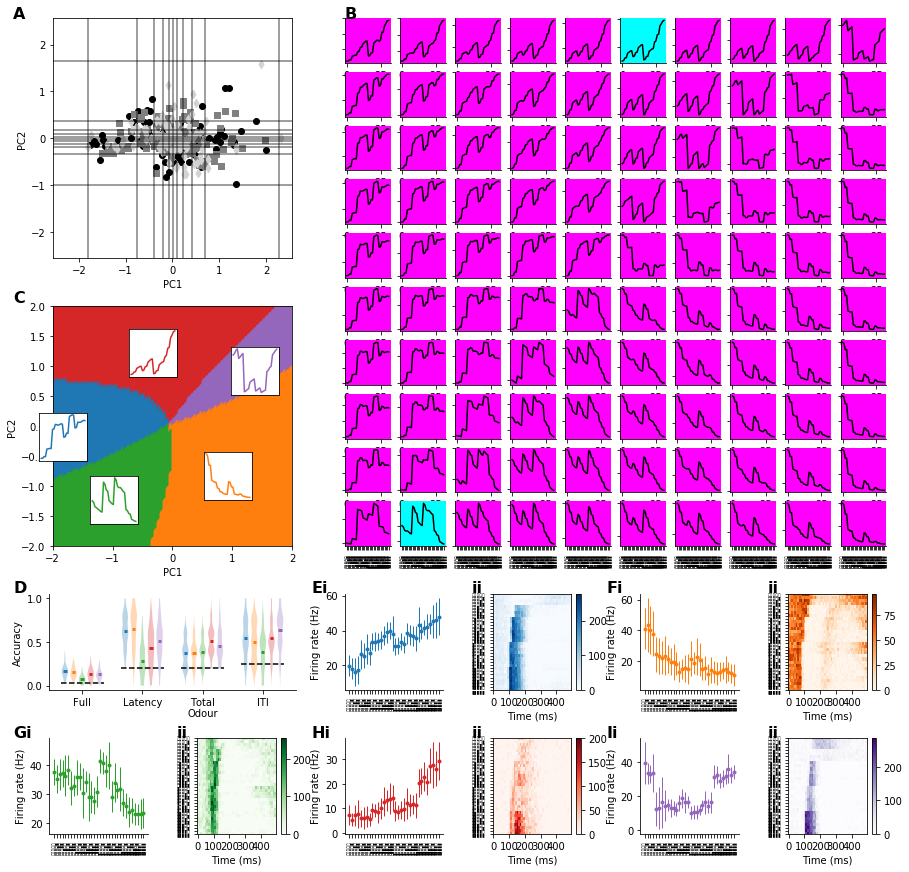

In [12]:
## Figure plotting - needs to be run TWICE because I calculate the scaling for B
## after plotting 

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(6, 6, figure=fig, hspace=0.5, wspace=0.5)

### The response map ax (part B)
response_map_ax = fig.add_subplot(gs[:4, 2:], frameon=False)
response_map_ax.set_xticks([])
response_map_ax.set_yticks([])

max_counts = plot_response_map(fig, gs[:4, 2:], max_counts)

### Make the axis for part A, the scatter plot
pc_ax = fig.add_subplot(gs[:2, :2], aspect='equal')
plot_scatter_and_pos(pc_ax)

### Make the axis for the archetypes (part C)
arc_ax = fig.add_subplot(gs[2:4, :2], aspect='equal')
plot_archetypes(arc_ax, all_pred_fits)

### Make the axis for the violin plots (part D)
violin_ax = fig.add_subplot(gs[4, :2])
plot_acc_violins(violin_ax)

### Make the axis for the example cell responses (part E-I)
examp_ax11 = fig.add_subplot(gs[4, 2])
examp_ax12 = fig.add_subplot(gs[4, 3])
examp_ax21 = fig.add_subplot(gs[4, 4])
examp_ax22 = fig.add_subplot(gs[4, 5])
examp_ax31 = fig.add_subplot(gs[5, 0])
examp_ax32 = fig.add_subplot(gs[5, 1])
examp_ax41 = fig.add_subplot(gs[5, 2])
examp_ax42 = fig.add_subplot(gs[5, 3])
examp_ax51 = fig.add_subplot(gs[5, 4])
examp_ax52 = fig.add_subplot(gs[5, 5])
plot_selected_cell_response(unit_usrt_j, 348, ax=examp_ax11, color='C0')
plot_selected_cell_heatmap(unit_usrt_j, 348, ax=examp_ax12, cmap='Blues')
plot_selected_cell_response(unit_usrt_j, 162, ax=examp_ax21, color='C1')
plot_selected_cell_heatmap(unit_usrt_j, 162, ax=examp_ax22, cmap='Oranges')
plot_selected_cell_response(unit_usrt_j, 233, ax=examp_ax31, color='C2')
plot_selected_cell_heatmap(unit_usrt_j, 233, ax=examp_ax32, cmap='Greens')
plot_selected_cell_response(unit_usrt_j, 50, ax=examp_ax41, color='C3')
plot_selected_cell_heatmap(unit_usrt_j, 50, ax=examp_ax42, cmap='Reds')
plot_selected_cell_response(unit_usrt_j, 37, ax=examp_ax51, color='C4')
plot_selected_cell_heatmap(unit_usrt_j, 37, ax=examp_ax52, cmap='Purples')

### Label the axes
axes = [pc_ax, response_map_ax, arc_ax, violin_ax, examp_ax11, examp_ax12, examp_ax21, examp_ax22, examp_ax31, examp_ax32, examp_ax41, examp_ax42, examp_ax51, examp_ax52]
labels = ['A', 'B', 'C', 'D', 'Ei', 'ii', 'Fi', 'ii', 'Gi', 'ii', 'Hi', 'ii', 'Ii', 'ii']
align_x = [[0, 2, 3, 8], [5, 11], [6, 12], [7, 13]]
align_y = [[0, 1], [3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13]]
label_axes.label_axes(axes, labels, fontsize=16, fontweight='bold', align_x=align_x, align_y=align_y)
#plt.savefig('230703_fig6.pdf', bbox_inches='tight')

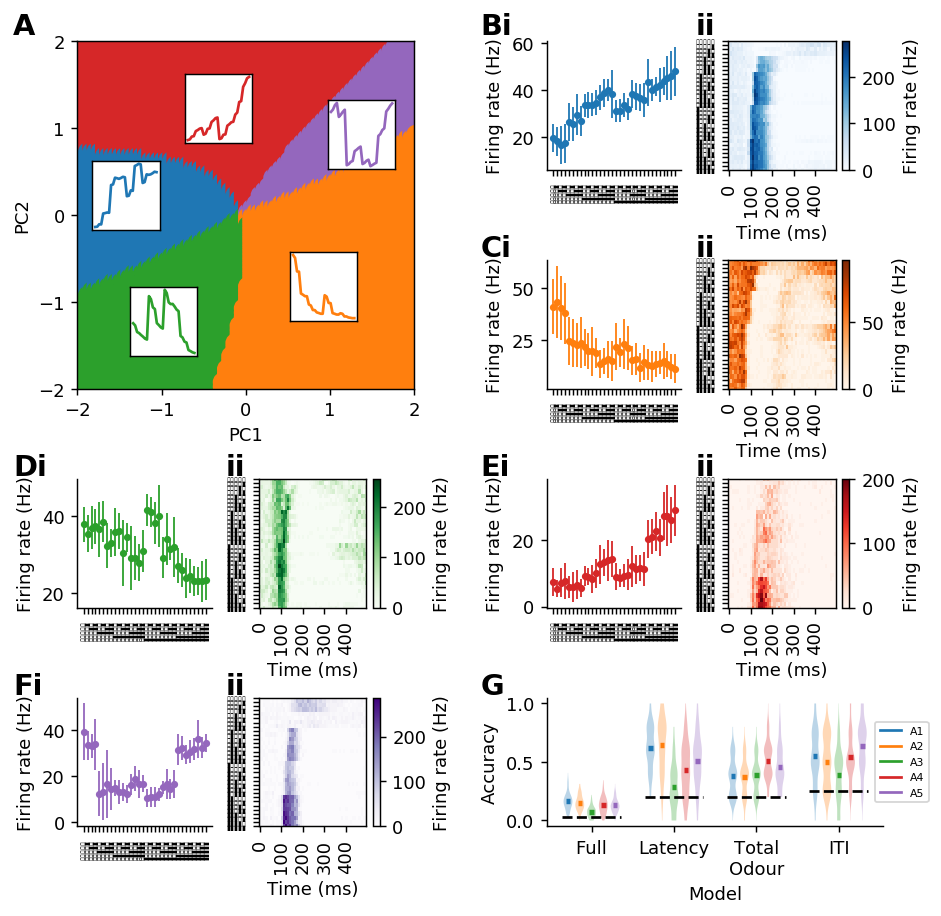

In [13]:
fig = plt.figure(figsize=(8, 8), dpi=130)
gs = fig.add_gridspec(4, 4, hspace=0.7, wspace=1.3)
def plot_select_cell_response_and_heatmap(fig, gs, unit_usrt_j, unit_id, color_cmap, tickfontsize=4, wspace=0.5, rotation=True, cbar_label=None, heatmap_shift=0.0):
    sub_gs = gs.subgridspec(1, 2, wspace=wspace)
    ax1 = fig.add_subplot(sub_gs[0])
    ax2 = fig.add_subplot(sub_gs[1])
    plot_selected_cell_response(unit_usrt_j, unit_id, ax=ax1, color=color_cmap[0], tickfontsize=tickfontsize)
    cbar = plot_selected_cell_heatmap(unit_usrt_j, unit_id, ax=ax2, cmap=color_cmap[1], tickfontsize=tickfontsize, rotate_xticks=rotation, cbar_label=cbar_label)
    ax2_pos = ax2.get_position()
    ax2.set_position([ax2_pos.x0+heatmap_shift, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
    cbar_pos = cbar.ax.get_position()
    cbar.ax.set_position([cbar_pos.x0+heatmap_shift, cbar_pos.y0, cbar_pos.width, cbar_pos.height])
    return ax1, ax2
fs = 4
space_ax = fig.add_subplot(gs[:2, :2])
dx = [0.1, 0, 0, 0, 0]
dy = [0.1, 0, 0, 0, 0]
plot_archetypes(space_ax, all_pred_fits, dx=dx, dy=dy)
space_ax.set_yticks([-2, -1, 0, 1, 2])
heatmap_shift = -0.02
sax11, sax12 = plot_select_cell_response_and_heatmap(fig, gs[0, 2:4], unit_usrt_j, 348, ['C0', 'Blues'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift)
sax21, sax22 = plot_select_cell_response_and_heatmap(fig, gs[1, 2:4], unit_usrt_j, 162, ['C1', 'Oranges'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift)
sax31, sax32 = plot_select_cell_response_and_heatmap(fig, gs[2, :2], unit_usrt_j, 233, ['C2', 'Greens'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift)
sax41, sax42 = plot_select_cell_response_and_heatmap(fig, gs[2, 2:4], unit_usrt_j, 50, ['C3', 'Reds'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift)
sax51, sax52 = plot_select_cell_response_and_heatmap(fig, gs[3, :2], unit_usrt_j, 37, ['C4', 'Purples'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift)

violin_ax = fig.add_subplot(gs[3, 2:])
plot_acc_violins(violin_ax)
violin_ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), fontsize=6)
violin_ax.set_xlabel('Model')

axes = [space_ax, sax11, sax12, sax21, sax22, sax31, sax32, sax41, sax42, sax51, sax52, violin_ax]
labels = ['A', 'Bi', 'ii', 'Ci', 'ii', 'Di', 'ii', 'Ei', 'ii', 'Fi', 'ii', 'G']
align_x = [[0, 5, 9], [1, 3, 7, 11], [2, 4, 8], [6, 10]]
align_y = [[0, 1, 2], [3, 4], [5, 6, 7, 8], [9, 10, 11]]
label_axes.label_axes(axes, labels, fontsize=16, fontweight='bold', align_x=align_x, align_y=align_y, align_x_fun=np.min, align_y_fun=np.max)

#plt.savefig('230821_Fig6.pdf', bbox_inches='tight')


In [14]:
print(unit_usrt_j[0, 0].shape)

(11, 50)


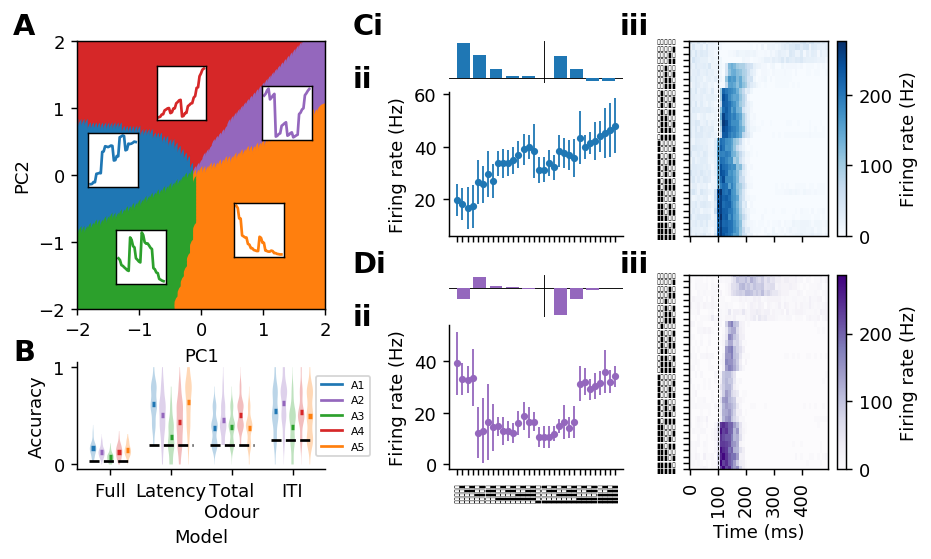

In [29]:
def plot_select_cell_response_and_heatmap(fig, gs, unit_usrt_j, unit_id, color_cmap, tickfontsize=4, wspace=0.5, rotation=True, cbar_label=None, heatmap_shift=0.0, show_model_weights=False):
    sub_gs = gs.subgridspec(1, 2, wspace=wspace)
    axs = []
    if show_model_weights:
        sub_sub_gs = sub_gs[0].subgridspec(4, 1)
        ax1 = fig.add_subplot(sub_sub_gs[1:])
        model_ax = fig.add_subplot(sub_sub_gs[0])
        xs = [0, 1, 2, 3, 4] + [6, 7, 8, 9]
        model_ax.bar(xs, diff_models_j[unit_id].opt_out.x[:-1], color=color_cmap[0])
        model_ax.spines['right'].set_visible(False)
        model_ax.spines['top'].set_visible(False)
        model_ax.spines['left'].set_visible(False)
        model_ax.spines['bottom'].set_visible(False)
        model_ax.set_xticks([])
        model_ax.axhline(0, zorder=-1, color='k', linewidth=0.5)
        model_ax.set_yticks([])
        model_ax.axvline(5, zorder=-1, color='k', linewidth=0.5)
        axs.append(model_ax)
    else:
        ax1 = fig.add_subplot(sub_gs[0])
    axs.append(ax1)
    ax2 = fig.add_subplot(sub_gs[1])
    plot_selected_cell_response(unit_usrt_j, unit_id, ax=ax1, color=color_cmap[0], tickfontsize=tickfontsize)
    cbar = plot_selected_cell_heatmap(unit_usrt_j, unit_id, ax=ax2, cmap=color_cmap[1], tickfontsize=tickfontsize, rotate_xticks=rotation, cbar_label=cbar_label)
    ax2_pos = ax2.get_position()
    ax2.set_position([ax2_pos.x0+heatmap_shift, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
    cbar_pos = cbar.ax.get_position()
    cbar.ax.set_position([cbar_pos.x0+heatmap_shift, cbar_pos.y0, cbar_pos.width, cbar_pos.height])
    axs.append(ax2)
    return axs

fig = plt.figure(figsize=(8, 6), dpi=130)
gs = fig.add_gridspec(4, 5, hspace=0.5, wspace=2)
space_ax = fig.add_subplot(gs[:2, :2])
dx = [0.1, 0, 0, 0, 0]
dy = [0.1, 0, 0, 0, 0]
plot_archetypes(space_ax, all_pred_fits, dx=dx, dy=dy)
violin_ax = fig.add_subplot(gs[2, :2])
plot_acc_violins(violin_ax, swap_positions=[1, 4])
violin_ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize=6)
violin_ax.set_xlabel('Model')
sub_gs = gs[:3, 2:].subgridspec(2, 1, wspace=0)
# sub_gs = gs[:2, :].subgridspec(2, 1, wspace=0.3)
max1, sax11, sax12 = plot_select_cell_response_and_heatmap(fig, sub_gs[0], unit_usrt_j, 348, ['C0', 'Blues'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift, show_model_weights=True)
max2, sax21, sax22 = plot_select_cell_response_and_heatmap(fig, sub_gs[1], unit_usrt_j, 37, ['C4', 'Purples'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift, show_model_weights=True)
sax11.set_xticklabels([])
sax12.set_xticklabels([])
sax12.set_xlabel('')
sax12.axvline(10, color='k', linestyle='--', linewidth=0.5)
sax22.axvline(10, color='k', linestyle='--', linewidth=0.5)
axes = [space_ax, violin_ax, max1, sax11, sax12, max2, sax21, sax22]
labels = ['A', 'B', 'Ci', 'ii', 'iii', 'Di', 'ii', 'iii']
align_x = [[0, 1], [2,3, 5, 6], [4, 7]]
align_y = [[0, 2, 4], [5, 7]]
dx = [0, 0, -0.035, -0.035, -0.035, -0.035, -0.035, -0.035]
label_axes.label_axes(axes, labels, fontsize=16, fontweight='bold', align_x=align_x, align_y=align_y, align_x_fun=np.min, align_y_fun=np.max, dx=dx)
plt.savefig('230908_Fig6.pdf', bbox_inches='tight')

In [32]:
print(np.array(iti_scores_limit).shape)

(5, 100)


In [34]:
print(np.mean(iti_scores_limit, axis=-1))
print(np.std(iti_scores_limit, axis=-1))

[0.5475 0.5025 0.3875 0.54   0.6325]
[0.23370655 0.22774712 0.23014941 0.20832667 0.22763732]


In [48]:
from scipy.stats import ttest_ind, f_oneway 
from statsmodels.stats.multicomp import MultiComparison
ttest_ind(iti_scores_limit[-1], iti_scores_limit[0])
f_oneway(*iti_scores_limit)
# Flatten the 2D array into 1D
iti_scores_limit = np.array(iti_scores_limit)
flattened_data = iti_scores_limit.flatten()

# Create labels for each condition (0, 1, 2, 3, 4 in this example)
labels = np.array([[i] * iti_scores_limit.shape[1] for i in range(iti_scores_limit.shape[0])]).flatten()

mc = MultiComparison(flattened_data, labels)


In [50]:
print(mc.tukeyhsd())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -0.045 0.6096 -0.1328  0.0428  False
     0      2    -0.16  0.001 -0.2478 -0.0722   True
     0      3  -0.0075    0.9 -0.0953  0.0803  False
     0      4    0.085 0.0633 -0.0028  0.1728  False
     1      2   -0.115 0.0034 -0.2028 -0.0272   True
     1      3   0.0375  0.742 -0.0503  0.1253  False
     1      4     0.13  0.001  0.0422  0.2178   True
     2      3   0.1525  0.001  0.0647  0.2403   True
     2      4    0.245  0.001  0.1572  0.3328   True
     3      4   0.0925 0.0333  0.0047  0.1803   True
----------------------------------------------------


In [34]:
all_pred_fits_diff = all_pred_fits.copy()


[0.00000000e+00 5.88871640e-07 2.13458954e-06 ... 9.99976681e-01
 9.99998156e-01 1.00000000e+00]
